In [3]:
import sys
import numpy as np
import torch
from torch import Tensor, ones, stack, load
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from scipy import stats

from tesladatadiff import TeslaDatasetDiff

sys.path.append("NeuralSolvers\") 
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [4]:
# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
normalize = 1000

In [5]:
# Create instance of the dataset
ds = TeslaDatasetDiff(device = device, normalize = normalize)

In [6]:

train_loader = DataLoader(dataset=ds, batch_size=2048, shuffle=False)
#next(iter(train_loader))

In [7]:
model = pf.models.MLP(input_size=5,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=ds.lb, 
                      ub=ds.ub,
                      activation = torch.relu)
model.cuda()

In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

Starting epoch 0
Loss after mini-batch    50: 0.98050901
Loss after mini-batch   100: 0.88647485
Loss after mini-batch   150: 1.32696022
Loss after mini-batch   200: 0.69645637
Epoch  0 Loss  0.9359577301966556
Starting epoch 1
Loss after mini-batch    50: 0.73994462
Loss after mini-batch   100: 0.83904933
Loss after mini-batch   150: 1.15856684
Loss after mini-batch   200: 0.71356318
Epoch  1 Loss  0.8327036487118025
Starting epoch 2
Loss after mini-batch    50: 0.60747319
Loss after mini-batch   100: 0.81335243
Loss after mini-batch   150: 1.08216478
Loss after mini-batch   200: 0.68641996
Epoch  2 Loss  0.7679696309363144
Starting epoch 3
Loss after mini-batch    50: 0.56673507
Loss after mini-batch   100: 0.78102699
Loss after mini-batch   150: 1.05809021
Loss after mini-batch   200: 0.65952814
Epoch  3 Loss  0.7390980549934192
Starting epoch 4
Loss after mini-batch    50: 0.60198806
Loss after mini-batch   100: 0.70279395
Loss after mini-batch   150: 0.85936638
Loss after mini-bat

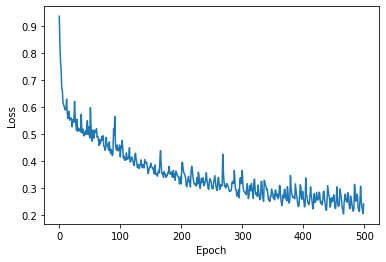

In [9]:
x_data_plot=[]
y_data_all_plot=[]

# Set fixed random number seed
torch.manual_seed(42)

Epochs = 500
for epoch in range(Epochs):
    # Print epoch
    print(f'Starting epoch {epoch}')
    
    # Set current and total loss value
    current_loss = 0.0
    total_loss = 0.0

    for i, data in enumerate(train_loader,0):

        x_batch, y_batch, delta_t = data
        optimizer.zero_grad()
        prediction = model(x_batch.to(device)) #GPU
        loss = criterion(prediction,y_batch.to(device))  #GPU
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_loss += loss.item()

        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.8f' %
                  (i + 1, current_loss / 50))
            current_loss = 0.0

    #print("Epoch ", epoch, "Loss ", loss.item())
    print("Epoch ", epoch, "Loss ", total_loss/(i+1))

    x_data_plot.append(epoch)
    y_data_all_plot.append(total_loss/(i+1))

# Make the plot of Loss vs epochs
plt.plot(x_data_plot,y_data_all_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

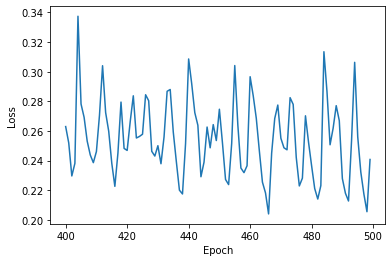

In [10]:
# Plot of last 100 epochs
plt.plot(x_data_plot[-100:],y_data_all_plot[-100:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
# Make a prediction
pred = model(ds.x.float().to(device)) #GPU
pred = pred.detach().cpu().numpy()/normalize

# ground-truth
df_y_tensor_np = ds.y.numpy()/normalize

In [12]:
# Some statistics
mae = np.sum(np.abs(pred- df_y_tensor_np).mean(axis=None))
print('MAE:', mae)

mse = ((df_y_tensor_np - pred)**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(pred - df_y_tensor_np) / np.linalg.norm(df_y_tensor_np)
print('Relative error (%):', rel_error*100)


MAE: 0.0002851739
MSE: 2.8261516e-07
Relative error (%): 49.29070770740509


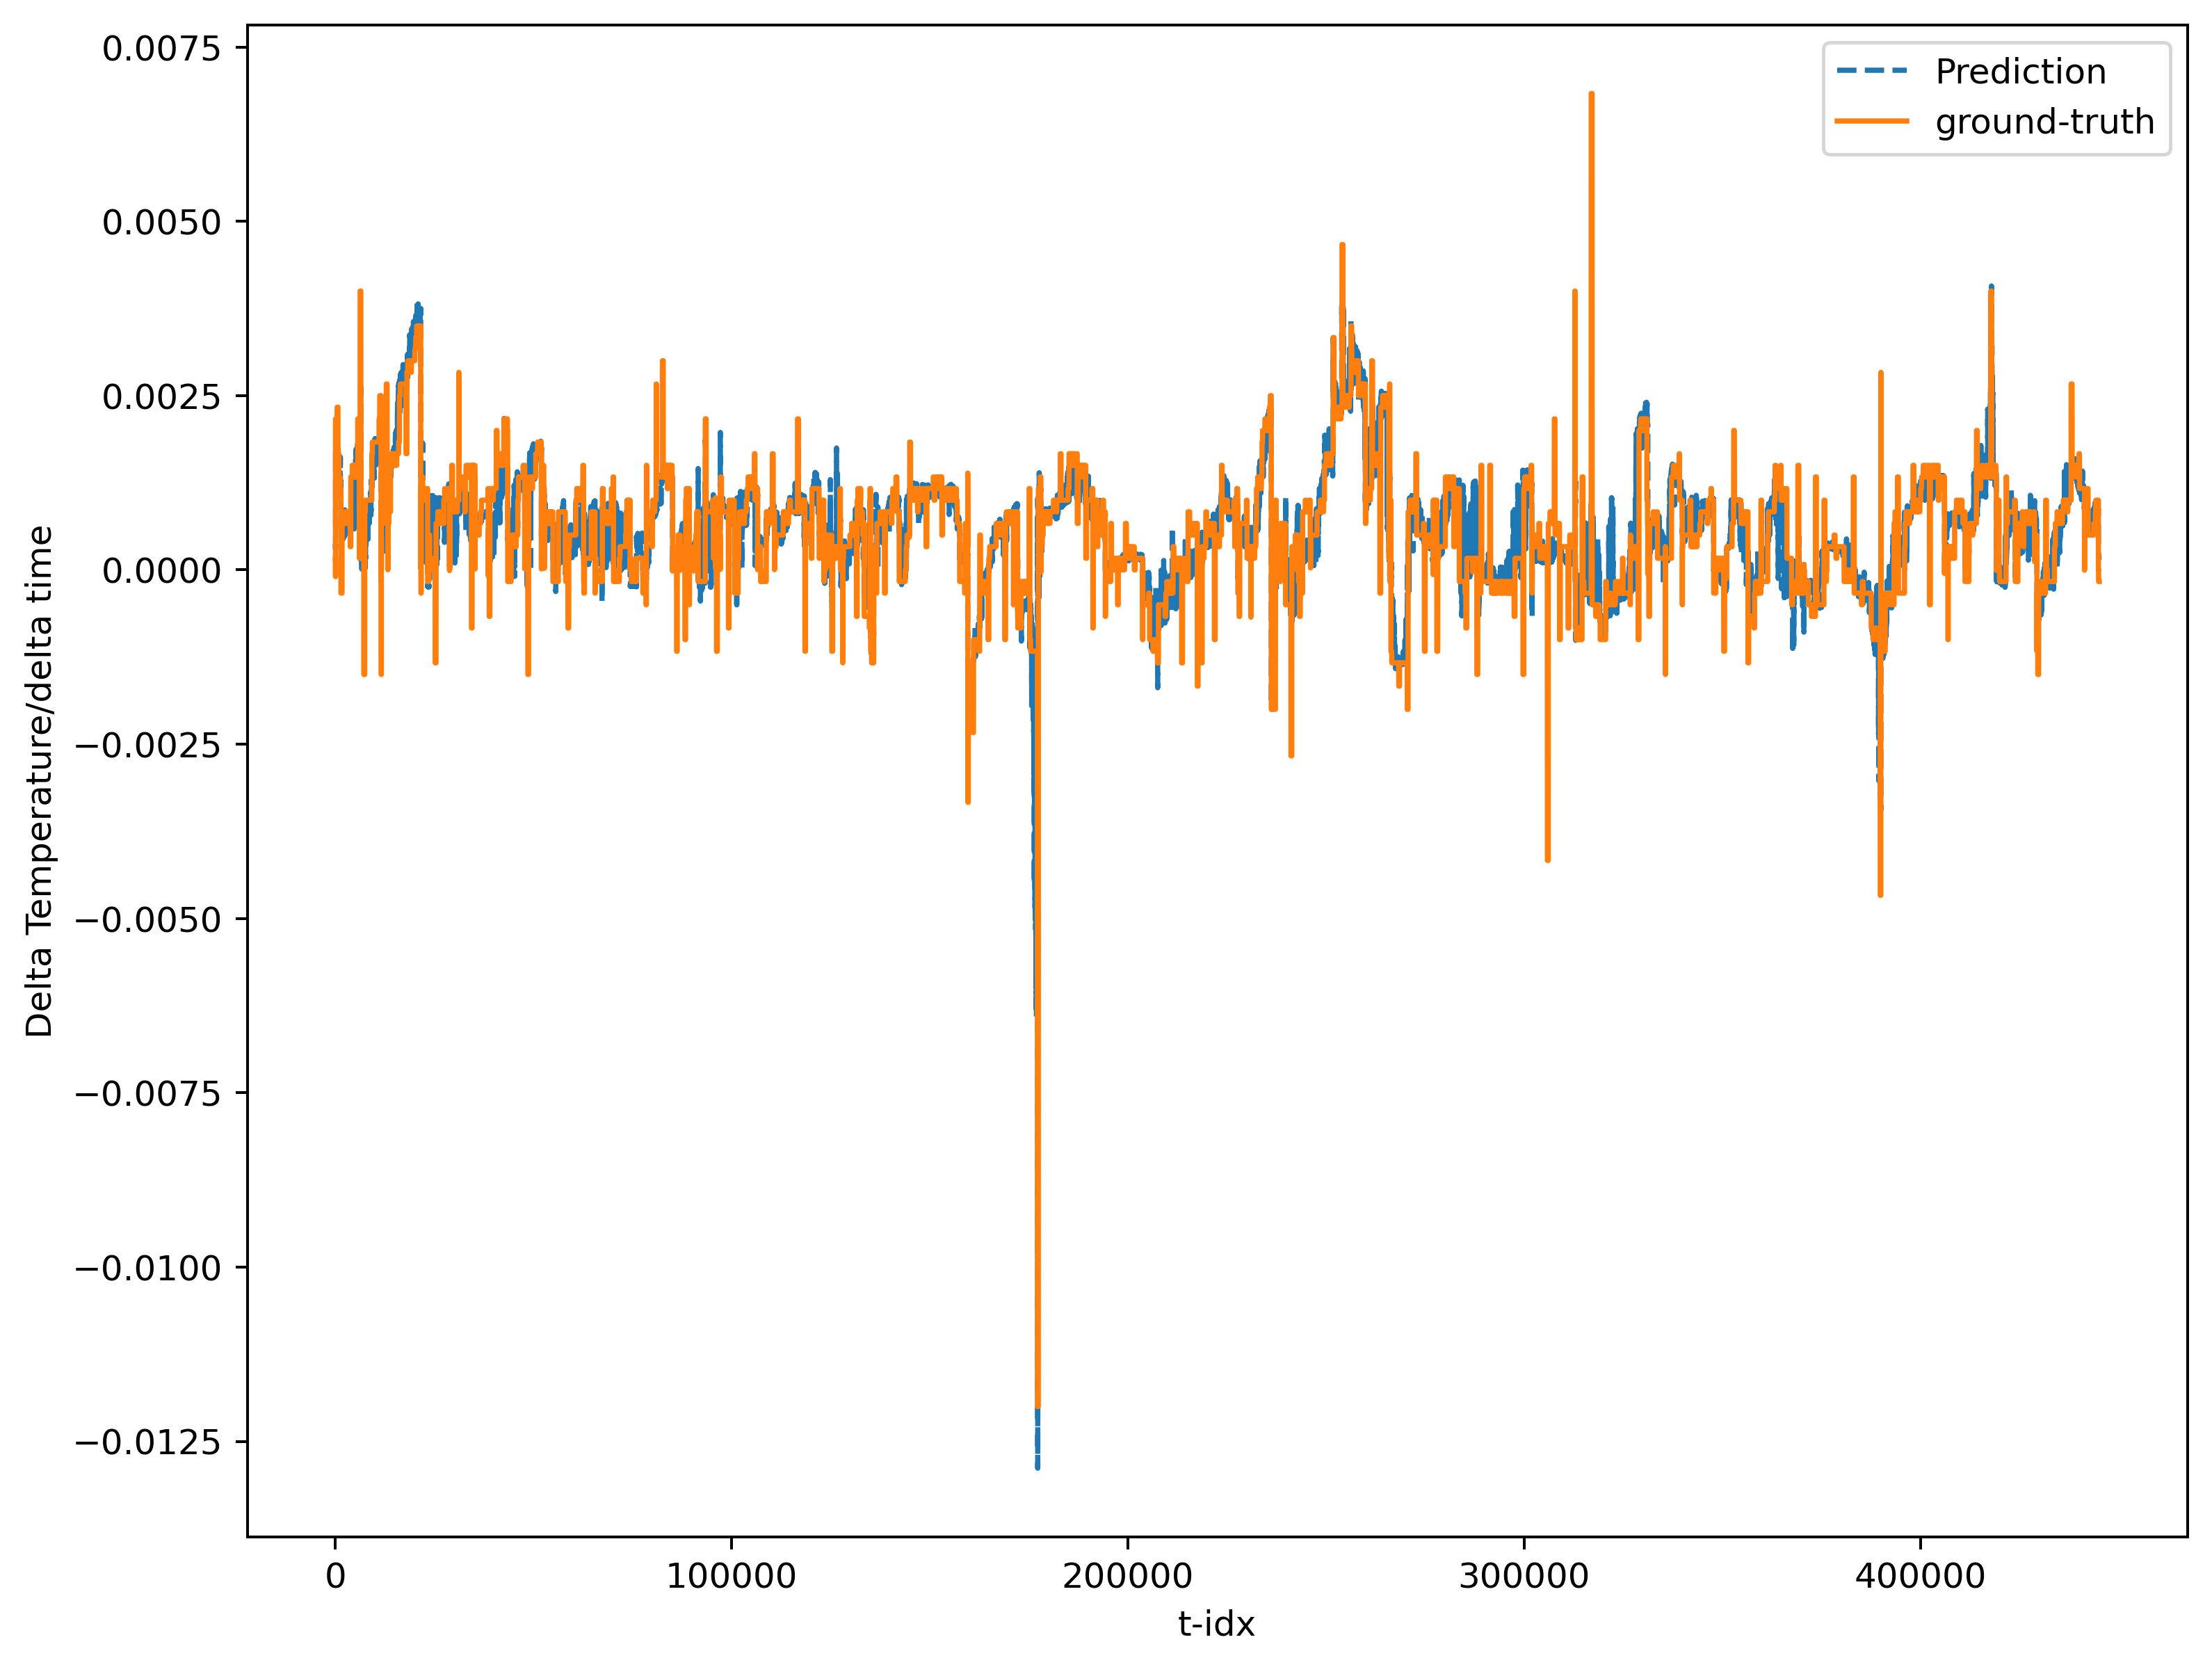

In [13]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('t-idx')
plt.ylabel('Delta Temperature/delta time')
plt.show()



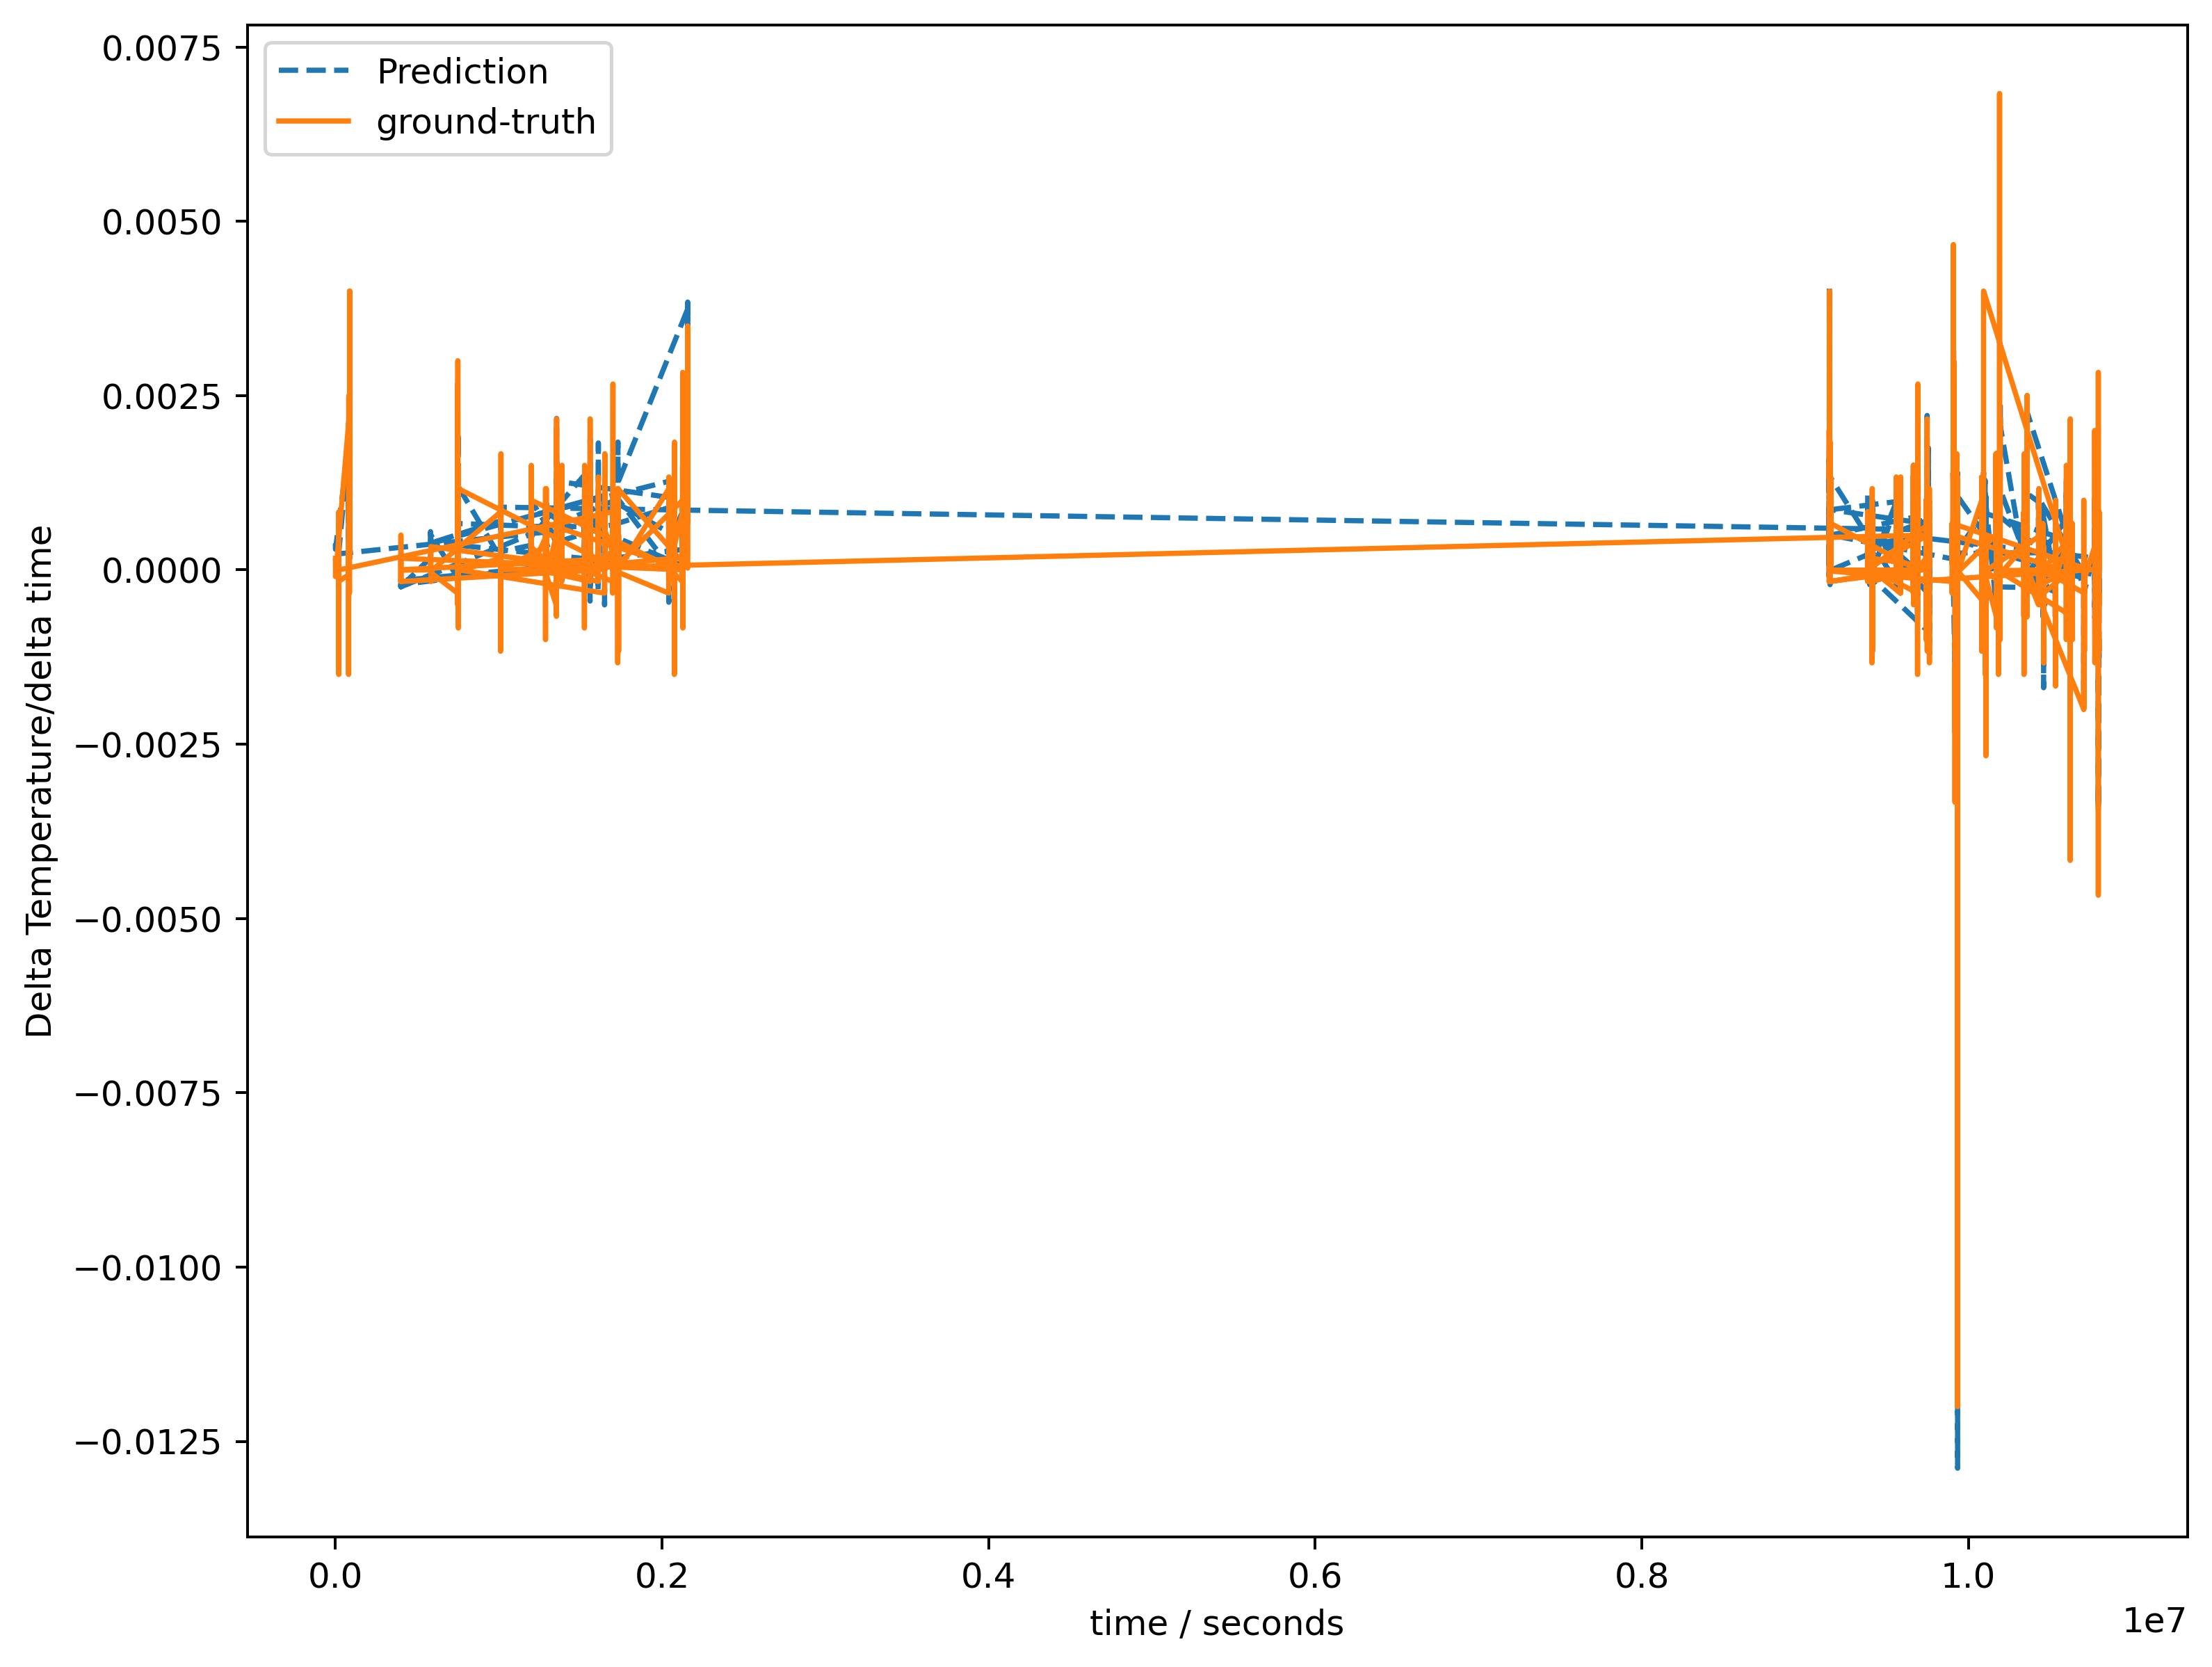

In [14]:
figure(figsize=(10, 8), dpi= 360)

#time
t=ds.t

plt.plot(t,pred, '--')
plt.plot(t,df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('time / seconds')
plt.ylabel('Delta Temperature/delta time')
plt.show()

In [15]:
# Import a slice of the datase (based on drive-id) for further analysis
ds = TeslaDatasetDiff(device = device, ID = 30)

MAE: 0.037848014
MSE: 0.0025893494
Relative error (%): 1.5283710323274136


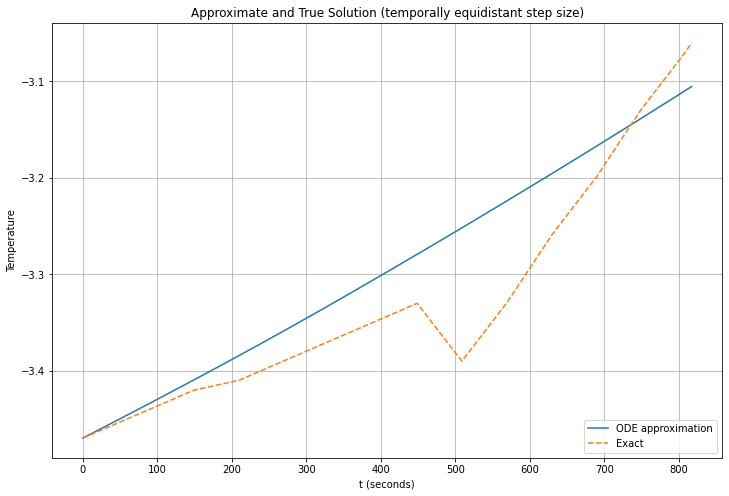

In [16]:
#Forward Euler method with fixed initial conditions but with updated 
#Temperature from the prediction of the model at previous iteration
#with generated temporally equidistant time steps

# ground-truth time
t=ds.t
max_t = t.max()

# Ground-truth temperature
true_temp = ds.x[:,4].numpy()

# Predicted temperature using model prediction and forward euler method
pred_temp = np.zeros((ds.x.shape[0]))
pred_temp = true_temp.copy()

# Fixed initial conditions for all environmental conditions
input = ds.x[0].detach().clone()

# temporally equdistant time steps
tt = np.linspace(0,max_t,ds.x.shape[0])
step_size=tt[2]-tt[1]

#ODE
for i in range(0, ds.x.shape[0] - 1):
      input[4] = torch.tensor(pred_temp[i]).detach().clone()
      pred = model(input.to(device))
      pred = pred.detach().cpu().numpy()/normalize
      pred_temp[i + 1] = pred_temp[i] + pred*step_size


#MAE
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

#Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(tt, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate and True Solution (temporally equidistant step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()

MAE: 0.043298997
MSE: 0.0031443776
Relative error (%): 1.6842277720570564


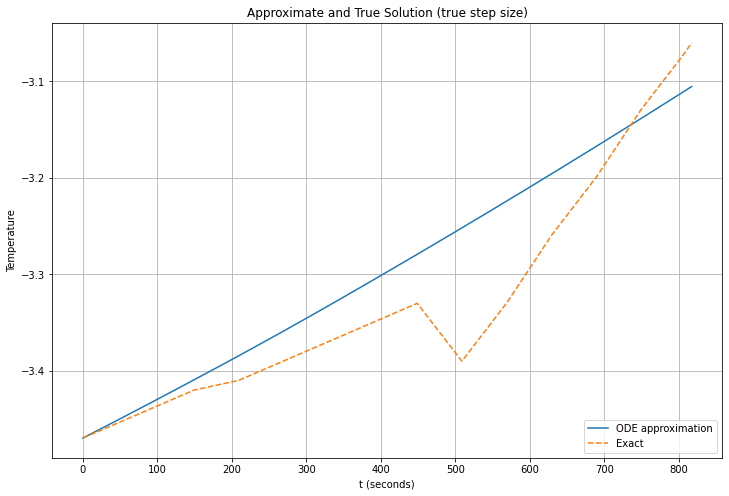

In [17]:
#Forward Euler method with fixed initial conditions but with updated 
#Temperature from the prediction of the model at previous iteration
#with true step sizes

# ground-truth time
t=ds.t
max_t = t.max()
t=t.numpy()

# Ground-truth temperature
true_temp = ds.x[:,4].numpy()

# Predicted temperature using model prediction and forward euler method
pred_temp = np.zeros((ds.x.shape[0]))
pred_temp = true_temp.copy()

# Fixed initial conditions for all environmental conditions
input = ds.x[0].detach().clone()

# temporally equdistant time steps
tt = np.linspace(0,max_t,ds.x.shape[0])
step_size=tt[2]-tt[1]

# ODE
for i in range(0, ds.x.shape[0] - 1):
      #input = df_xx_tensor[0]
      input[4] = torch.tensor(pred_temp[i]).detach().clone()
      pred = model(input.to(device))
      pred = pred.detach().cpu().numpy()/normalize
      pred_temp[i + 1] = pred_temp[i] + pred*(t[i+1]-t[i])
      
#MAE 
mae = np.sum(np.abs(pred_temp- true_temp).mean(axis=None))
print('MAE:', mae)

#MSE
mse = ((true_temp - pred_temp)**2).mean(axis=None)
print('MSE:', mse)

# Relative error
rel_error = np.linalg.norm(pred_temp - true_temp) / np.linalg.norm(true_temp)
print('Relative error (%):', rel_error*100)

plt.figure(figsize = (12, 8))
plt.plot(t, pred_temp, '-', label='ODE approximation')
plt.plot(t, true_temp, '--', label='Exact')
plt.title('Approximate and True Solution (true step size)')
plt.xlabel('t (seconds)')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()


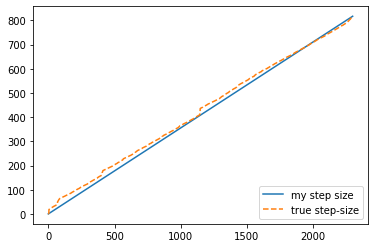

In [18]:
plt.plot(tt, '-', label='my step size')
plt.plot(t, '--', label='true step-size')
plt.legend(loc='lower right')

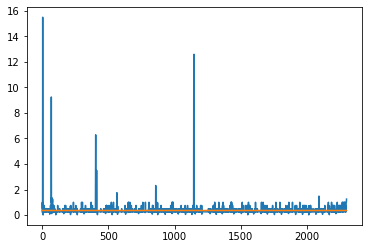

In [19]:
plt.plot(np.diff(t.reshape(-1)))
plt.plot(np.diff(tt.reshape(-1)))